<a href="https://colab.research.google.com/github/louisechilds/ADS2002-Catheter/blob/main/KMeans_Multiclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KMeans Multiclassification of Catheters

If they are normal, abnormal or borderline.

As some of them have multiple catheters and the output from the kmeans model only defines it in one of the categories, it is still defined as a negative if they have a normal and an abnormal or borderline catheter.

## Setting things up

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import recall_score
from sklearn.metrics import adjusted_rand_score

from sklearn.metrics import silhouette_score

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

train=pd.read_csv('train.csv')
train_annot=pd.read_csv('train_annotations.csv')

In [ ]:
directory_path='/projects/sc73/ranzcr-clip-catheter-line-classification/train'

In [ ]:
#separate by normal or something else for each type of catheter
test_CVC=train[['StudyInstanceUID','CVC - Abnormal','CVC - Normal','CVC - Borderline']]
test_CVC=test_CVC.drop(test_CVC[(test_CVC['CVC - Abnormal'] == 0) & (test_CVC['CVC - Normal'] == 0) & (test_CVC['CVC - Borderline'] == 0)].index)
test_ETT=train[['StudyInstanceUID','ETT - Abnormal','ETT - Normal','ETT - Borderline']]
test_ETT=test_ETT.drop(test_ETT[(test_ETT['ETT - Abnormal'] == 0) & (test_ETT['ETT - Normal'] == 0) & (test_ETT['ETT - Borderline'] == 0)].index)
test_NGT=train[['StudyInstanceUID','NGT - Abnormal','NGT - Normal','NGT - Borderline','NGT - Incompletely Imaged']]
test_NGT=test_NGT.drop(test_NGT[(test_NGT['NGT - Abnormal'] == 0) & (test_NGT['NGT - Normal'] == 0) & (test_NGT['NGT - Borderline'] == 0) & (test_NGT['NGT - Incompletely Imaged']==0)].index)
test_NGT=test_NGT.drop(test_NGT[(test_NGT['NGT - Incompletely Imaged']==1)].index)

In [ ]:
def add_feature(df, folder):
    if 'image' not in df.columns:
        df['image'] = ''

    for i, row in df.iterrows():
        filename = row['StudyInstanceUID'] + '.jpg'
        image_path = os.path.join(folder, filename)
        image = Image.open(image_path).convert('L')  # Open and convert to grayscale
        image = np.array(image)
       #image = image.resize((300, 300))  # Resize to manageable dimensions
        df.at[i, 'image'] = image  # Set the 'image' column with the Pillow Image object

    return df

In [ ]:
def remove_suffix(text, suffix):
    """Remove the specified suffix from the given text."""
    if text.endswith(suffix):
        return text[:-len(suffix)]
    return text

In [ ]:
from PIL import Image

Using just the first 750 images

In [ ]:
directory_files = os.listdir(directory_path)
for i in range(750):
    directory_files[i]=remove_suffix(directory_files[i], '.jpg')

cvc_images_train=test_CVC.loc[train['StudyInstanceUID'].isin(directory_files)]
ngt_images_train=test_NGT.loc[train['StudyInstanceUID'].isin(directory_files)]
ett_images_train=test_ETT.loc[train['StudyInstanceUID'].isin(directory_files)]
cvc=add_feature(cvc_images_train,directory_path)
ngt=add_feature(ngt_images_train,directory_path)
ett=add_feature(ett_images_train,directory_path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## CVC Multiclassification

In [ ]:
cvc.head()

,StudyInstanceUID,CVC - Abnormal,CVC - Normal,CVC - Borderline,image
11,1.2.826.0.1.3680043.8.498.84472839875948876829...,0,1,0,"[[26, 37, 78, 119, 130, 126, 122, 114, 89, 57,..."
13,1.2.826.0.1.3680043.8.498.71008408169501434503...,0,1,0,"[[81, 87, 102, 113, 100, 72, 52, 48, 36, 31, 2..."
66,1.2.826.0.1.3680043.8.498.33717345723466709327...,0,1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
67,1.2.826.0.1.3680043.8.498.26255946920569788246...,0,1,0,"[[10, 10, 10, 9, 9, 8, 8, 8, 6, 6, 6, 6, 6, 6,..."
124,1.2.826.0.1.3680043.8.498.41219045795159738970...,0,1,0,"[[3, 4, 5, 6, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6,..."


In [ ]:
len(cvc)

731

In [ ]:
shapes = []
for i in range(len(cvc)):
  shapes.append(cvc.iloc[i].iat[4].shape)
min(shapes)

new_cvc = cvc.copy()
new_cvc['image'] = new_cvc['image'].apply(lambda x: np.resize(x, min(shapes)))
flat_copy = new_cvc.copy()
flat_copy['image'] = flat_copy['image'].apply(lambda x: np.array(x).flatten())

In [ ]:
X = np.stack(flat_copy['image'].values)
Y = flat_copy[['CVC - Normal', 'CVC - Abnormal', 'CVC - Borderline']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit the K-Means model on the training data
cvc_kmeans = KMeans(n_clusters=3, random_state = 42)
clusters = cvc_kmeans.fit(X_train)

y_preds = cvc_kmeans.predict(X_test)

#Find the accuracy
correct = 0
for i in range(len(y_preds)):
    if y_test.iloc[i].iat[y_preds[i]] == 1:
        correct += 1
accuracy = correct/len(y_preds)
print(f"CVC Accuracy: {np.round(accuracy,3)}")

CVC Accuracy: 0.361


In [ ]:
silhouette_avg = silhouette_score(X_test, y_preds)
print("Silhouette Score:", np.round(silhouette_avg,3))

Silhouette Score: 0.105


This is quite a poor accuracy score. Additionally, this silhouette score is quite close to zero, implying that many samples were close to the boundaries of clusters however it is still positive so there was some correct definition.

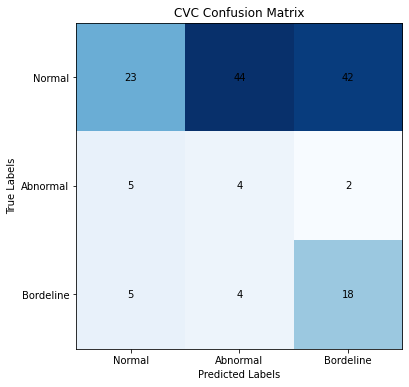

In [ ]:
new_y_test = []
for i in np.array(y_test):
    new_y_test.append(np.argmax(i))
# Calculate the confusion matrix
conf_matrix = confusion_matrix(new_y_test, y_preds)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.xticks([0, 1, 2], ['Normal', 'Abnormal', 'Bordeline'])
plt.yticks([0, 1, 2], ['Normal', 'Abnormal', 'Bordeline'])
plt.title('CVC Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display the annotations on the heatmap
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

plt.show()

## NGT Multiclassification

In [ ]:
ngt.head()

,StudyInstanceUID,NGT - Abnormal,NGT - Normal,NGT - Borderline,NGT - Incompletely Imaged,image
66,1.2.826.0.1.3680043.8.498.33717345723466709327...,0,1,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
204,1.2.826.0.1.3680043.8.498.75289336873032144148...,0,1,0,0,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
363,1.2.826.0.1.3680043.8.498.36885100611708351610...,0,1,0,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
370,1.2.826.0.1.3680043.8.498.61214074150651249100...,0,1,0,0,"[[2, 3, 4, 5, 5, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3,..."
592,1.2.826.0.1.3680043.8.498.12359997132910172428...,0,1,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
len(ngt)

137

In [ ]:
shapes = []
for i in range(len(ngt)):
  shapes.append(ngt.iloc[i].iat[5].shape)
min(shapes)

new_ngt = ngt.copy()
new_ngt['image'] = new_ngt['image'].apply(lambda x: np.resize(x, min(shapes)))
flat_copy = new_ngt.copy()
flat_copy['image'] = flat_copy['image'].apply(lambda x: np.array(x).flatten())

In [ ]:
X = np.stack(flat_copy['image'].values)
Y = flat_copy[['NGT - Normal', 'NGT - Abnormal', 'NGT - Borderline']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit the K-Means model on the training data
ngt_kmeans = KMeans(n_clusters=3, random_state = 42)
clusters = ngt_kmeans.fit(X_train)

y_preds = ngt_kmeans.predict(X_test)

#Find the accuracy
correct = 0
for i in range(len(y_preds)):
    if y_test.iloc[i].iat[y_preds[i]] == 1:
        correct += 1
accuracy = correct/len(y_preds)
print(f"NGT Accuracy: {np.round(accuracy,3)}")

NGT Accuracy: 0.357


In [ ]:
silhouette_avg = silhouette_score(X_test, y_preds)
print("Silhouette Score:", np.round(silhouette_avg,3))

Silhouette Score: 0.193


This resulted in an even worse accuracy and lower solhouette score than the previous model. This silhouette score indicates even less well definied clusters with only a small amount of correct classification.

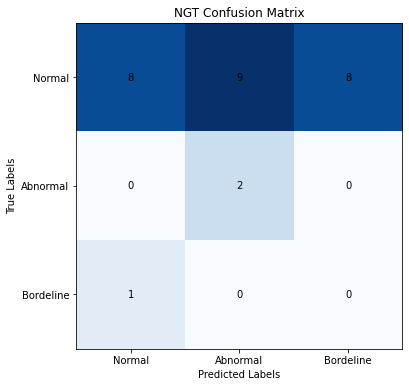

In [ ]:
new_y_test = []
for i in np.array(y_test):
    new_y_test.append(np.argmax(i))
# Calculate the confusion matrix
conf_matrix = confusion_matrix(new_y_test, y_preds)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.xticks([0, 1, 2], ['Normal', 'Abnormal', 'Bordeline'])
plt.yticks([0, 1, 2], ['Normal', 'Abnormal', 'Bordeline'])
plt.title('NGT Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display the annotations on the heatmap
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

plt.show()

## ETT Multiclassification

In [ ]:
ett.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Normal,ETT - Borderline,image
66,1.2.826.0.1.3680043.8.498.33717345723466709327...,0,1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
204,1.2.826.0.1.3680043.8.498.75289336873032144148...,0,0,1,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
370,1.2.826.0.1.3680043.8.498.61214074150651249100...,0,1,0,"[[2, 3, 4, 5, 5, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3,..."
642,1.2.826.0.1.3680043.8.498.22634208733796493768...,0,1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
842,1.2.826.0.1.3680043.8.498.43451491315844703199...,0,1,0,"[[6, 7, 10, 12, 12, 12, 10, 9, 7, 9, 10, 10, 9..."


In [ ]:
len(ett)

190

In [ ]:
shapes = []
for i in range(len(ett)):
  shapes.append(ett.iloc[i].iat[4].shape)
min(shapes)

new_ett = ett.copy()
new_ett['image'] = new_ett['image'].apply(lambda x: np.resize(x, min(shapes)))
flat_copy = new_ett.copy()
flat_copy['image'] = flat_copy['image'].apply(lambda x: np.array(x).flatten())

In [ ]:
X = np.stack(flat_copy['image'].values)
Y = flat_copy[['ETT - Normal', 'ETT - Abnormal', 'ETT - Borderline']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit the K-Means model on the training data
ett_kmeans = KMeans(n_clusters=3, random_state = 42)
clusters = ett_kmeans.fit(X_train)

y_preds = ett_kmeans.predict(X_test)

#Find the accuracy
correct = 0
tp = 0

for i in range(len(y_preds)):
    if y_test.iloc[i].iat[y_preds[i]] == 1:
        correct += 1
accuracy = correct/len(y_preds)
print(f"ETT Accuracy: {np.round(accuracy,3)}")

ETT Accuracy: 0.474


In [ ]:
silhouette_avg = silhouette_score(X_test, y_preds)
print("Silhouette Score:", np.round(silhouette_avg,3))

Silhouette Score: 0.151


This model has the worst accuracy overall however it does result in a slightly improved silhouette score over the previous model.

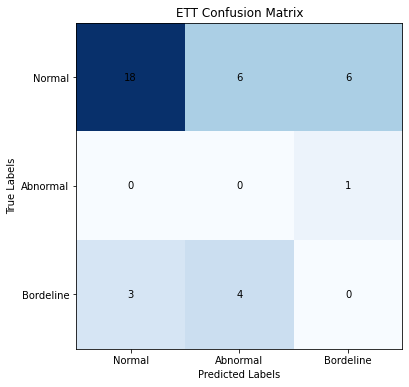

In [ ]:
new_y_test = []
for i in np.array(y_test):
    new_y_test.append(np.argmax(i))
# Calculate the confusion matrix
conf_matrix = confusion_matrix(new_y_test, y_preds)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.xticks([0, 1, 2], ['Normal', 'Abnormal', 'Bordeline'])
plt.yticks([0, 1, 2], ['Normal', 'Abnormal', 'Bordeline'])
plt.title('ETT Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display the annotations on the heatmap
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

plt.show()